# Guided Project: Decision trees for garment industry




## Table of contents
1. [Introduction](#introduction)
2. [Data Exploration](#data_exploration)
3. [Data Cleaning](#data_cleaning)
4. [Model Construction](#model_construction)
5. [Model Evaluation](#model_evaluation)
6. [Model Improvement](#model_improvement)
7. [Model Results](#model_results)
8. [Conclusion](#conclusion)


## Introduction <a id="introduction"></a>
We'll be looking at the garment industry and some stats about employees and productive shifts using decision trees.



In [1]:
import logging
import warnings

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier

# Matplot lib puts up some warnings that get noisy
logging.getLogger("matplotlib").setLevel(logging.ERROR)
# Suppress FutureWarnings from scikit-learn when using pipelines about them not being fit
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
df = pd.read_csv('garments_worker_productivity.csv')

## Data Exploration <a id="data_exploration"></a>

The dataset is from a garment manufacturer about worker productivity and is available
(https://archive.ics.uci.edu/dataset/597/productivity+prediction+of+garment+employees). The manufacturer is based in Bangladesh, and workers
were paid in Bangladeshi Taka (**৳** / **BDT**). The data represents about 2.5 months of work from the start of 2015

### Data Schema



| **Variable Name**       | **Role** | **Type**    | **Description**                                                                            | **Units** | **Missing Values** |
|-------------------------|----------|-------------|--------------------------------------------------------------------------------------------|-----------|--------------------|
| `date`                  | Feature  | Date        | Date in MM-DD-YYYY                                                                         |           | no                 |
| `quarter`               | Feature  | Categorical | A portion of the month. A month was divided into four quarters                             |           | no                 |
| `department`            | Feature  | Categorical | Associated department with the instance                                                    |           | no                 |
| `day`                   | Feature  | Categorical | Day of the Week                                                                            |           | no                 |
| `team_no`               | Feature  | Integer     | Associated team number with the instance                                                   |           | no                 |
| `no_of_workers`         | Feature  | Integer     | Number of workers in each team                                                             |           | no                 |
| `no_of_style_change`    | Feature  | Integer     | Number of changes in the style of a particular product                                     |           | no                 |
| `targeted_productivity` | Feature  | Continuous  | Targeted productivity set by the Authority for each team for each day.                     |           | no                 |
| `smv`                   | Feature  | Continuous  | Standard Minute Value, it is the allocated time for a task                                 |           | no                 |
| `wip`                   | Feature  | Integer     | Work in progress. Includes the number of unfinished items for products                     |           | yes                |
| `over_time`             | Feature  | Integer     | Represents the amount of overtime by each team in minutes                                  |           | no                 |
| `incentive`             | Feature  | Integer     | Represents the amount of financial incentive (in BDT) that enables or motivates a behavior | BDT       | no                 |
| `idle_time`             | Feature  | Integer     | The amount of time when the production was <br/>interrupted due to several reasons         |           | no                 |
| `idle_men`              | Feature  | Integer     | The number of workers who were idle due to production interruption                         |           | no                 |
| `actual_productivity`   | Target   | Continuous  | The actual % of productivity that was delivered by the workers. It ranges from 0-1.        |           | no                 |

In [3]:
df.head()
df.shape

(1197, 15)

In [4]:

df['productive'] = (df['actual_productivity'] > df['targeted_productivity']).astype(int)


~ 1200 rows and 14 features

### Missing values
The schema indicates there is some missing data for the `wip` feature. Let's take a look

In [5]:
df['wip'].describe()

count      691.000000
mean      1190.465991
std       1837.455001
min          7.000000
25%        774.500000
50%       1039.000000
75%       1252.500000
max      23122.000000
Name: wip, dtype: float64

In [6]:
non_numeric_count = df['wip'].apply(pd.to_numeric, errors='coerce').isnull().sum()
print("Number of non-numeric values:", non_numeric_count)

Number of non-numeric values: 506


It looks about a half of the data set is missing that for this feature. That's too much to exclude

In [7]:
zero_count = (df['wip'] == 0).sum()
print("Number of 0 values in 'wip':", zero_count)

Number of 0 values in 'wip': 0


It's reasonable to assume since there's no zero values, and Works In Progress (WIP) is an integer representing the
amount of garments still to be made, that a lack of entry could be considered to be zero, so we'll impute that

In [8]:
missing_count_by_dept = df.groupby('department')['wip'].apply(lambda x: x.isnull().sum())
print("Number of missing values in 'wip' by department:\n", missing_count_by_dept)

Number of missing values in 'wip' by department:
 department
finishing     249
finishing     257
sweing          0
Name: wip, dtype: int64


The sewing department is the only one with Works In Progress being tracked. The finishing department is either not
tracking works in progress or always completes all works. There's also two strings representing the finishing
department that will need to be merged, caused by extra whitespace

### Data shapes

In [9]:
unique_counts = {col: df[col].nunique() for col in df.columns}
unique_counts

{'date': 59,
 'quarter': 5,
 'department': 3,
 'day': 6,
 'team': 12,
 'targeted_productivity': 9,
 'smv': 70,
 'wip': 548,
 'over_time': 143,
 'incentive': 48,
 'idle_time': 12,
 'idle_men': 10,
 'no_of_style_change': 3,
 'no_of_workers': 61,
 'actual_productivity': 879,
 'productive': 2}

There's 2 `department`s, 12 `team`s, 61 team sizes, interestingly, the `targeted_productivity` and the
`actual_productivity` have about two orders of magnitude difference. Indicating that for a given `target_productivity`
there could be 10 to 100 values for it's `actual_productivity`

In [10]:
{col: df[col].unique() for col in ['team', 'idle_time', 'idle_men', 'no_of_style_change', 'targeted_productivity']}

{'team': array([ 8,  1, 11, 12,  6,  7,  2,  3,  9, 10,  5,  4]),
 'idle_time': array([  0. ,  90. , 150. , 270. , 300. ,   2. ,   5. ,   8. ,   4.5,
          3.5,   4. ,   6.5]),
 'idle_men': array([ 0, 10, 15, 45, 37, 30, 35, 20, 25, 40]),
 'no_of_style_change': array([0, 1, 2]),
 'targeted_productivity': array([0.8 , 0.75, 0.7 , 0.65, 0.6 , 0.35, 0.5 , 0.07, 0.4 ])}

Let's add a label feature to mark a shift as productive if it's actual productivity equaled or exceeded its target

In [11]:
df['productive'] = (df['actual_productivity'] >= df['targeted_productivity']).astype(int)
df.head()

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity,productive
0,1/1/2015,Quarter1,sweing,Thursday,8,0.80,26.16,1108.0,7080,98,0.0,0,0,59.0,0.940725,1
1,1/1/2015,Quarter1,finishing,Thursday,1,0.75,3.94,NaN,960,0,0.0,0,0,8.0,0.886500,1
2,1/1/2015,Quarter1,sweing,Thursday,11,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570,1
3,1/1/2015,Quarter1,sweing,Thursday,12,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570,1
4,1/1/2015,Quarter1,sweing,Thursday,6,0.80,25.90,1170.0,1920,50,0.0,0,0,56.0,0.800382,1


In [12]:
df['idle_time'].value_counts()

idle_time
0.0      1179
3.5         3
2.0         2
8.0         2
4.0         2
4.5         2
5.0         2
90.0        1
270.0       1
150.0       1
300.0       1
6.5         1
Name: count, dtype: int64

In [13]:

df['productive'] = (df['actual_productivity'] > df['targeted_productivity']).astype(int)
df.head()


,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity,productive
0,1/1/2015,Quarter1,sweing,Thursday,8,0.80,26.16,1108.0,7080,98,0.0,0,0,59.0,0.940725,1
1,1/1/2015,Quarter1,finishing,Thursday,1,0.75,3.94,NaN,960,0,0.0,0,0,8.0,0.886500,1
2,1/1/2015,Quarter1,sweing,Thursday,11,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570,1
3,1/1/2015,Quarter1,sweing,Thursday,12,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570,1
4,1/1/2015,Quarter1,sweing,Thursday,6,0.80,25.90,1170.0,1920,50,0.0,0,0,56.0,0.800382,1


Only 18 `idle_time` values that are non-zero, interesting. Probably indicating this feature is not going to be a
great predictor of productivity given the limited data, but it would be unfair to ignore it

In [14]:
df['idle_men'].value_counts()

idle_men
0     1179
10       3
15       3
30       3
20       3
35       2
37       1
45       1
25       1
40       1
Name: count, dtype: int64

There's 18 non-zero values for `idle_men` as well. Let's take a look at those data entries

In [15]:
df[(df['idle_men'] > 0) & (df['idle_time'] > 0)]

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity,productive
615,2/4/2015,Quarter1,sweing,Wednesday,5,0.65,30.10,326.0,5820,0,90.0,10,0,58.5,0.650835,1
617,2/4/2015,Quarter1,sweing,Wednesday,4,0.35,30.10,287.0,6060,23,150.0,15,0,55.5,0.350706,1
650,2/7/2015,Quarter1,sweing,Saturday,7,0.70,24.26,658.0,6960,0,270.0,45,0,58.0,0.662270,0
654,2/7/2015,Quarter1,sweing,Saturday,8,0.70,24.26,652.0,6840,0,300.0,37,0,57.0,0.365319,0
775,2/15/2015,Quarter3,sweing,Sunday,8,0.70,30.10,507.0,5880,40,2.0,10,1,59.0,0.700573,1
798,2/16/2015,Quarter3,sweing,Monday,8,0.70,30.10,7.0,7080,27,2.0,10,2,59.0,0.621972,0
818,2/17/2015,Quarter3,sweing,Tuesday,8,0.60,29.40,179.0,0,23,5.0,30,2,58.0,0.600983,1
822,2/17/2015,Quarter3,sweing,Tuesday,10,0.65,18.22,741.0,0,0,8.0,35,1,49.0,0.302117,0
841,2/18/2015,Quarter3,sweing,Wednesday,10,0.70,19.68,1119.0,5640,0,8.0,35,1,47.0,0.303574,0
843,2/18/2015,Quarter3,sweing,Wednesday,8,0.65,29.40,962.0,4560,0,4.5,30,2,57.0,0.251399,0


Looks like it was just the sewing department that had downtime

### Targeted vs Actual productivity

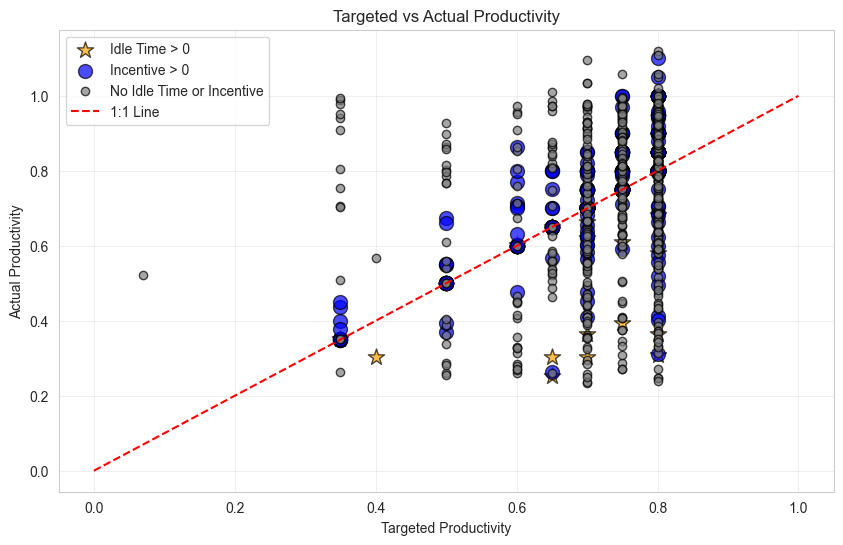

In [16]:
plt.figure(figsize=(10, 6))

# Create scatter plot for points with idle time > 0 (stars)
scatter_idle_time = plt.scatter(
    df[df['idle_time'] > 0]['targeted_productivity'],
    df[df['idle_time'] > 0]['actual_productivity'],
    marker='*', c='orange', label='Idle Time > 0', alpha=0.7, edgecolor='k', s=150
)

# Create scatter plot for points with incentive > 0 (colored differently)
scatter_incentive = plt.scatter(
    df[df['incentive'] > 0]['targeted_productivity'],
    df[df['incentive'] > 0]['actual_productivity'],
    marker='o', c='blue', label='Incentive > 0', alpha=0.7, edgecolor='k', s=100
)

# Create scatter plot for points with neither condition (default appearance)
scatter_default = plt.scatter(
    df[(df['idle_time'] == 0) & (df['incentive'] == 0)]['targeted_productivity'],
    df[(df['idle_time'] == 0) & (df['incentive'] == 0)]['actual_productivity'],
    marker='o', c='gray', label='No Idle Time or Incentive', alpha=0.7, edgecolor='k'
)

# Add a 1:1 line for targeted vs actual productivity
plt.plot([0, 1], [0, 1], 'r--', label='1:1 Line')

plt.title("Targeted vs Actual Productivity")
plt.xlabel("Targeted Productivity")
plt.ylabel("Actual Productivity")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

Everything above the red line represents a productive shift. There's clearly a data input error with the value of 0
.07 for targeted productivity

### Data distributions

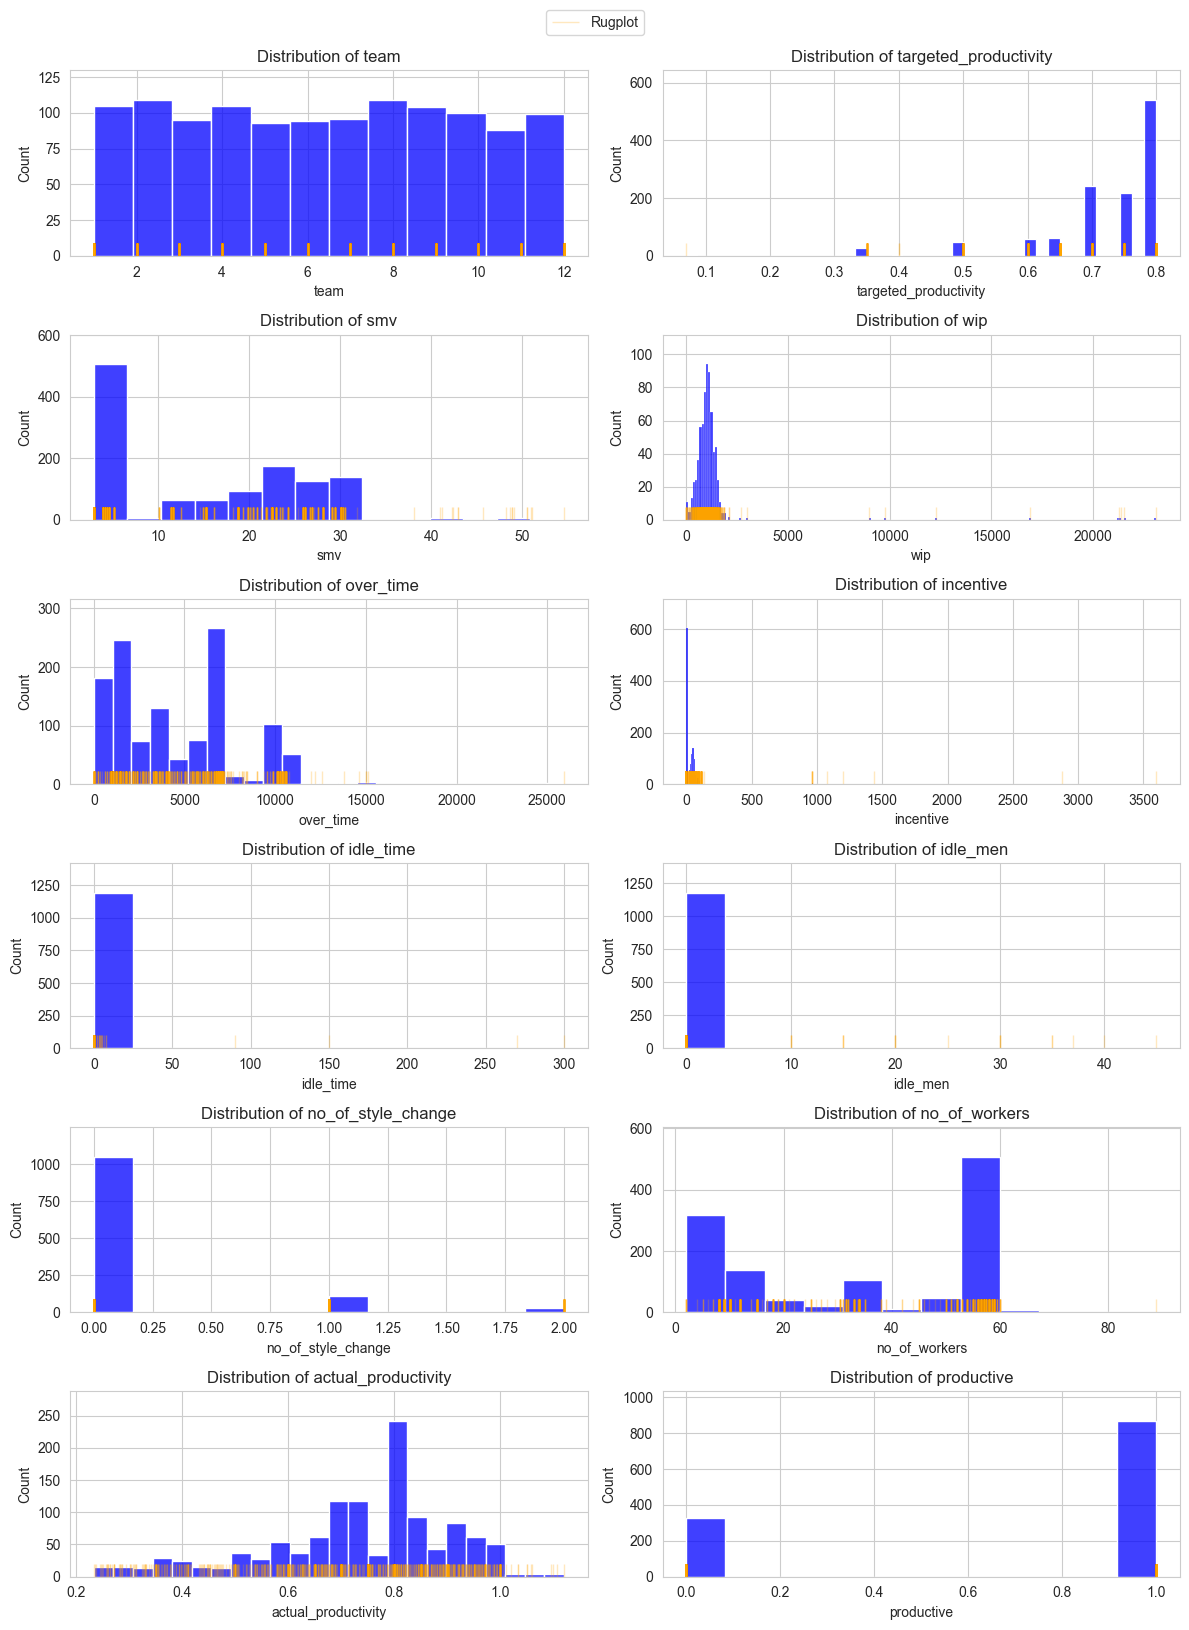

In [17]:
numeric_columns = df.select_dtypes(include=['number']).columns
plt.figure(figsize=(12, 16))  # Adjusted figure size to match two-column layout
for i, col in enumerate(numeric_columns, 1):
    plt.subplot((len(numeric_columns) + 1) // 2, 2, i)  # Two columns layout
    sns.histplot(df[col], kde=False, color='blue', bins='auto')  # Added histogram
    sns.rugplot(df[col], height=0.07, alpha=0.25, color='orange', label='Rugplot')  # Overlay rugplot
    plt.title(f'Distribution of {col}')
    plt.tight_layout()

# Add a legend to the top of the overall figure
plt.figlegend(['Rugplot'], loc='upper center', ncol=1, bbox_to_anchor=(0.5, 1.02))

plt.show()

There's some interesting data

- for `wip` it seems normally distributed with a few outliers an order of magnitude higher. Possibly erroneous data
entry
- for `incentive` it seems normally distributed, with a few outliers much higher, but also a lot of shifts with no
incentive
- for `smv` over half of all garments have a less than 10 minute standard value
- for `no_of_style_change` vast majority of shifts there are no style changes

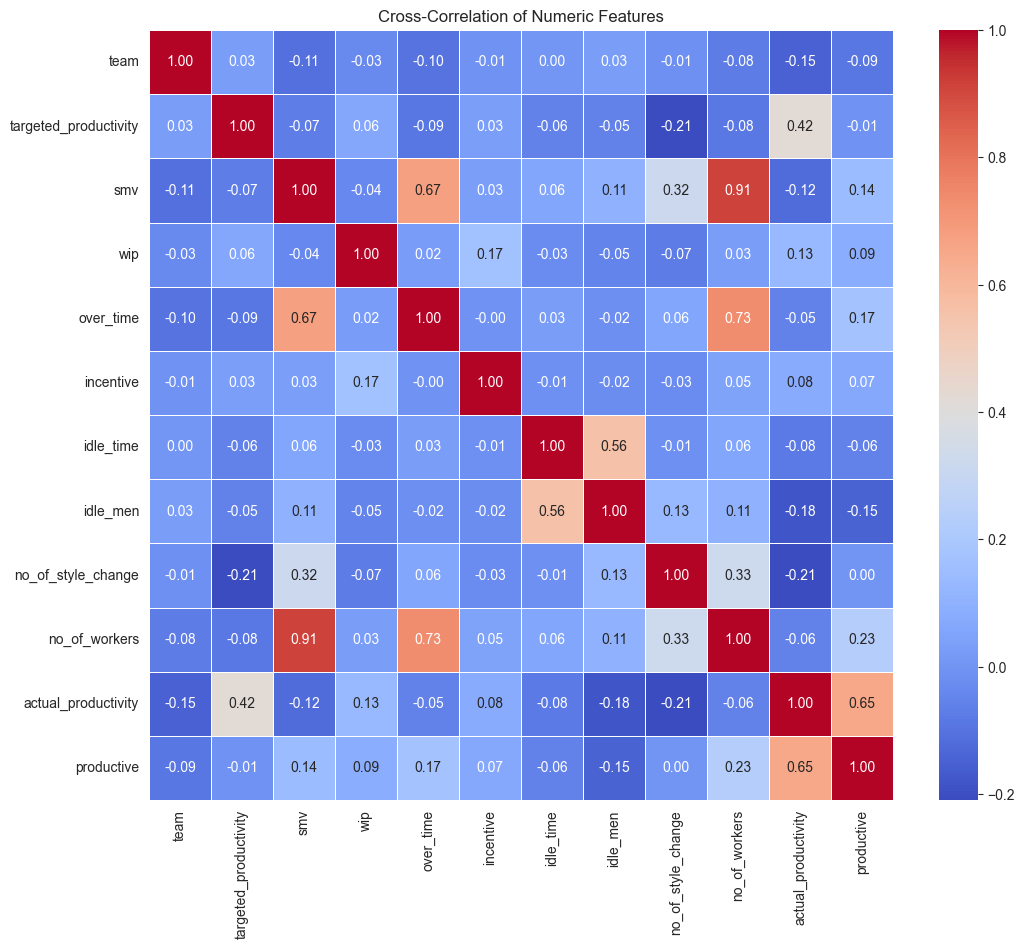

In [18]:
# Select only numeric columns for cross-correlation
numeric_features = df.select_dtypes(include=['number'])

# Calculate the correlation matrix for numeric features
correlation_matrix = numeric_features.corr()

# Plot the correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Cross-Correlation of Numeric Features")
plt.show()

The strong correlations for predicting whether a given entry is productive is the `no_of_workers`, `smv`, `wip` and
`over_time`

The most surprising insight from this is that the `incentive` has 0
correlation with `over_time`

### Summary

There's some features we will drop, because they have insufficient data to be useful given the total size of the data
 set
(`idle_time`,
`quarter`, `date`, `team_no`) or

| **Variable Name**       | **Cleaning?**                                | **Transformer** | **Keep Feature?** |
|-------------------------|----------------------------------------------|-----------------|-------------------|
| `date`                  | No                                           | none            | No                |
| `quarter`               | Merge Q5 into Q4                             | One-hot encode  | No                |
| `department`            | Fix string import                            | One-hot encode  | Yes               |
| `day`                   | None                                         | One-hot encode  | No                |
| `team_no`               | None                                         | One-hot encode  | No                |
| `no_of_workers`         | Handle outliers                              | Scale/normalize | Yes               |
| `no_of_style_change`    | None                                         | One-hot encode  | Yes               |
| `targeted_productivity` | Handle outliers, ensure 0-1 range            | None            | Yes               |
| `smv`                   | Handle outliers                              | Scale/normalize | Yes               |
| `wip`                   | Impute missing values as 0                   | Scale/normalize | Yes               |
| `over_time`             | Handle outliers normalise to `no_of_workers` | Scale/normalize | Yes               |
| `incentive`             | Handle outliers                              | Scale/normalize | Yes               |
| `idle_time`             | Handle outliers                              | Scale/normalize | No                |
| `idle_men`              | Handle outliers                              | Scale/normalize | No                |
| `actual_productivity`   | Ensure 0-1 range, rounding to 2 decimal      | None            | Yes               |




## Data Cleaning <a id="data_cleaning"></a>
There's some things that are easier to do in a pandas dataframe rather than building custom transformers and
pipelines. Dropping some data is one of them

In [19]:
# Drop rows where idle_men or idle_time are not zero
df = df[(df['idle_men'] == 0) & (df['idle_time'] == 0)]

In [20]:
df['avg_overtime_per_worker'] = df['over_time'] / df['no_of_workers']

### Correcting typo and whitespace
In the department column, there was whitespace after `finishing ` and a typo in `sweing`

In [21]:
df['department'] = df['department'].str.strip().replace("sweing", "sewing")
df['department'].value_counts()

department
sewing       673
finishing    506
Name: count, dtype: int64

### Correcting transposition errors
It was observed that for some entries. Data intended for the over_time column was entered into the incentive column.
Since the real incentive is unlikely to be more than 300. We can correct this.

In [22]:
# Correct transposition errors in 'incentive' and 'over_time' columns for values of 'incentive' > 300
mask = (df['over_time'] == 0) & (df['incentive'] > 300)
df.loc[mask, 'over_time'] = df.loc[mask, 'incentive']
df.loc[mask, 'incentive'] = 0

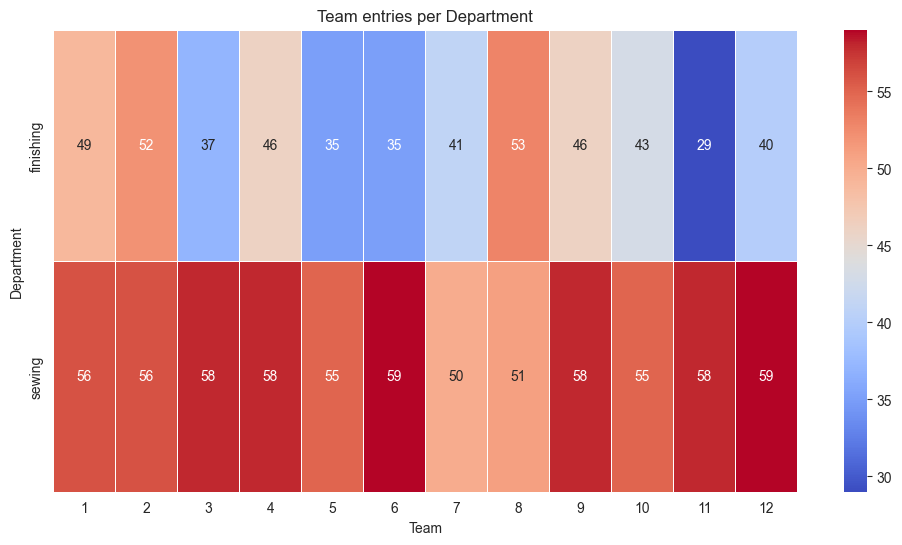

In [23]:
# Plot department vs team absolute counts
plt.figure(figsize=(12, 6))

# Create a cross-tabulation between department and team
cross_tab = pd.crosstab(df['department'], df['team'])

# Heatmap for visualizing the absolute counts of team usage per department
sns.heatmap(cross_tab, annot=True, cmap="coolwarm", fmt="d", linewidths=0.5)
plt.title('Team entries per Department')
plt.xlabel('Team')
plt.ylabel('Department')

plt.show()

The team numbers between sewing and finishing departments are reused but are different (there are ~20 entries per
day, representing 20 unique teams), so we need to combine the department and team_number (or drop team number entirely)

In [24]:
df['dept_team'] = df['department'] + "_" + df['team'].astype(str)

In [25]:
from sklearn.base import BaseEstimator, TransformerMixin


# Custom transformer to handle feature names
class CustomFunctionTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, func=None, feature_names_func=None, kw_args=None):
        self.func = func
        self.feature_names_func = feature_names_func
        self.transformer = FunctionTransformer(func)
        self.kw_args = kw_args if kw_args is not None else {}

    def fit(self, x, y=None):
        self.transformer.fit(x, y)
        return self

    def transform(self, x):
        return self.transformer.transform(x)

    def get_feature_names_out(self, input_features=None):
        if self.feature_names_func is not None:
            return self.feature_names_func(input_features)
        if input_features is not None:
            return input_features  # Default: return input feature names unmodified
        raise ValueError("input_features must be provided for feature name transformation")


# Example custom functions for each step
def remove_whitespace_transformer(y):
    if not isinstance(y, pd.DataFrame):
        y = pd.DataFrame(y)
    return y.map(lambda x: x.strip() if isinstance(x, str) else x)


def return_feature_names(input_features):
    return input_features  # No change in feature names for this step


remove_whitespace = CustomFunctionTransformer(
    func=remove_whitespace_transformer,
    feature_names_func=return_feature_names
)

# Updated Data Cleaning Transformer
data_cleaning_transformer = ColumnTransformer(
    transformers=[
            # Clean and encode department column
            ('dept_team', OneHotEncoder(sparse_output=False), ['dept_team']),
            # ('team', OneHotEncoder(sparse_output=False), ['team']),
            ('style_change', OneHotEncoder(sparse_output=False), ['no_of_style_change']),
            # Scale/normalize numeric columns
            ('scale_normalize', Pipeline(
                steps=[
                        ('impute_zeros', CustomFunctionTransformer(
                            func=lambda x: x.fillna(0),
                            feature_names_func=lambda x: x
                        )),
                        ('round_to_2_decimal', CustomFunctionTransformer(
                            func=lambda x: x.round(2),
                            feature_names_func=lambda x: x
                        )),
                ]
            ), [
                     'no_of_workers', 'targeted_productivity', 'smv', 'wip', 'avg_overtime_per_worker', 'over_time',
                     'incentive'
             ])
    ],
    remainder='drop'
).set_output(transform="pandas")

## Model Construction <a id="model_construction"></a>
### Splitting the data set
We'll train on 70% of the data set, reserve 15% for validation and 15% for test

In [26]:
X = df.drop('productive', axis=1)
Y = df['productive']

X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.3, random_state=42, stratify=Y)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42, stratify=Y_temp)

In [27]:
# Summarise these results in a table
summary_table = pd.DataFrame({
        'Set'             : ['X_train', 'X_val', 'X_test'],
        'Productive (1)'  : [Y_train.value_counts().get(1, 0), Y_val.value_counts().get(1, 0),
                             Y_test.value_counts().get(1, 0)],
        'Unproductive (0)': [Y_train.value_counts().get(0, 0), Y_val.value_counts().get(0, 0),
                             Y_test.value_counts().get(0, 0)]
}
)

print(summary_table)

       Set  Productive (1)  Unproductive (0)
0  X_train             605               220
1    X_val             130                47
2   X_test             130                47


Because all the splits have substantially more productive shifts than unproductive, we need a scorer that takes into
account the bias and weights the contributions of productive and unproductive shifts fairly. We'll use the Matthews
Correlation Coefficient [(MCC)](https://en.wikipedia.org/wiki/Phi_coefficient),
which can weight the contributions of each class to
 the final score based on their prevalance in the data set.

### Tree Classifier Pipeline

In [28]:
tree_pipeline = Pipeline(
    steps=[
            ('data_cleaning', data_cleaning_transformer),
            ('tree_model', DecisionTreeClassifier(random_state=42, max_depth=4))
    ]
)

### Model scoring
As we generate decision trees, we want a way to quickly visualise all the important figures about the performance of
the model. So we'll make a function to display the scores, and the confusion matrix in a nice way we can reuse.

In [29]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score, matthews_corrcoef
from sklearn.metrics import make_scorer

mcc_scorer = make_scorer(matthews_corrcoef)


def display_model_stats(model, x_val, y_val, title="Model Performance Metrics"):
    # Make predictions
    y_val_pred = model.predict(x_val)

    # Replace numerical labels with categorical ones for better readability
    y_val = y_val.map({0: 'unproductive', 1: 'productive'})
    y_val_pred = pd.Series(y_val_pred).map({0: 'unproductive', 1: 'productive'})

    # Calculate metrics
    precision = precision_score(y_val, y_val_pred, pos_label='productive')
    recall = recall_score(y_val, y_val_pred, pos_label='productive')
    f1 = f1_score(y_val, y_val_pred, pos_label='productive')
    m1 = matthews_corrcoef(
        y_val.map({'unproductive': 0, 'productive': 1}), y_val_pred.map({'unproductive': 0, 'productive': 1})
    )
    accuracy = accuracy_score(y_val, y_val_pred)

    # Sensitivity is the same as recall (true positive rate)
    sensitivity = recall

    # Specificity calculation
    conf_matrix = confusion_matrix(y_val, y_val_pred, labels=['unproductive', 'productive'])
    tn, fp, fn, tp = conf_matrix.ravel()
    specificity = tn / (tn + fp)

    # Display confusion matrix
    conf_matrix = confusion_matrix(y_val, y_val_pred, labels=['unproductive', 'productive'])

    # Plotting the metrics
    plt.figure(figsize=(12, 8))

    # Add a title over the entire figure
    plt.suptitle(title, fontsize=16, fontweight='bold')

    # Plot bar chart for metrics with numeric values displayed
    plt.subplot(1, 2, 1)
    metrics = ['Accuracy', 'Precision', 'Recall (Sensitivity)', 'Specificity', 'F1 Score', 'Matthews Corr. Coeff.']
    values = [accuracy, precision, sensitivity, specificity, f1, m1]
    sns.barplot(x=metrics, y=values, hue=metrics, dodge=False, palette="viridis")
    plt.ylim(0, 1)
    plt.title("Model Metrics")
    plt.xticks(rotation=45)
    for count, v in enumerate(values):
        plt.text(count, v + 0.02, f"{v:.2f}", color="black", ha="center")  # Add text to display metric values

    # Plot the confusion matrix
    plt.subplot(1, 2, 2)
    sns.heatmap(
        conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['unproductive', 'productive'],
        yticklabels=['unproductive', 'productive']
    )
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout for the main title
    plt.show()



In [30]:
tree_pipeline.fit(X_train, Y_train)

Pipeline(steps=[('data_cleaning',
                 ColumnTransformer(transformers=[('dept_team',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['dept_team']),
                                                 ('style_change',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['no_of_style_change']),
                                                 ('scale_normalize',
                                                  Pipeline(steps=[('impute_zeros',
                                                                   CustomFunctionTransformer(feature_names_func=<function <lambda> at 0x000001AFB1EDCCC0>,
                                                                                             func=<functi...
                                                                                             kw_args={})),
                                                                  ('round_to_2_decimal',
                                                                   CustomFunctionTransformer(feature_names_func=<function <lambda> at 0x000001AFB1EDDF80>,
                                                                                             func=<function <lambda> at 0x000001AFB1EDDB20>,
                                                                                             kw_args={}))]),
                                                  ['no_of_workers',
                                                   'targeted_productivity',
                                                   'smv', 'wip',
                                                   'avg_overtime_per_worker',
                                                   'over_time',
                                                   'incentive'])])),
                ('tree_model',
                 DecisionTreeClassifier(max_depth=4, random_state=42))])

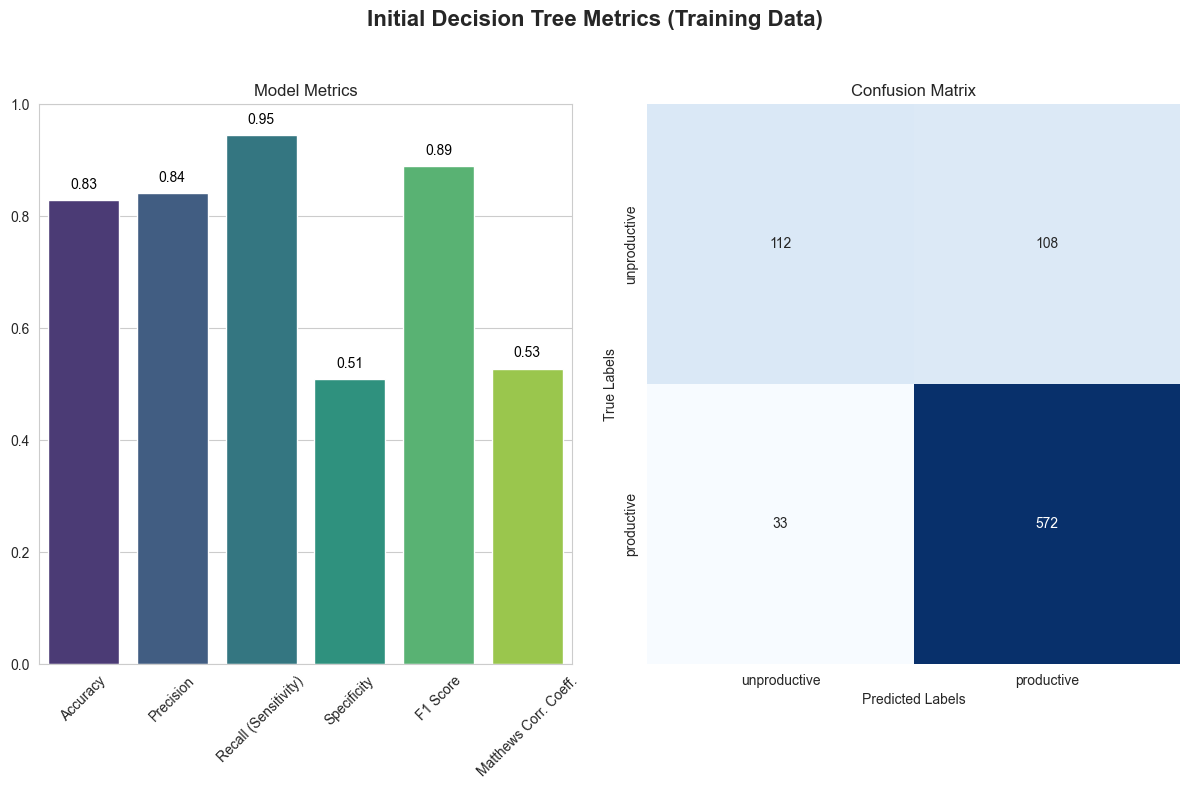

In [31]:
display_model_stats(tree_pipeline, X_train, Y_train, title="Initial Decision Tree Metrics (Training Data)")

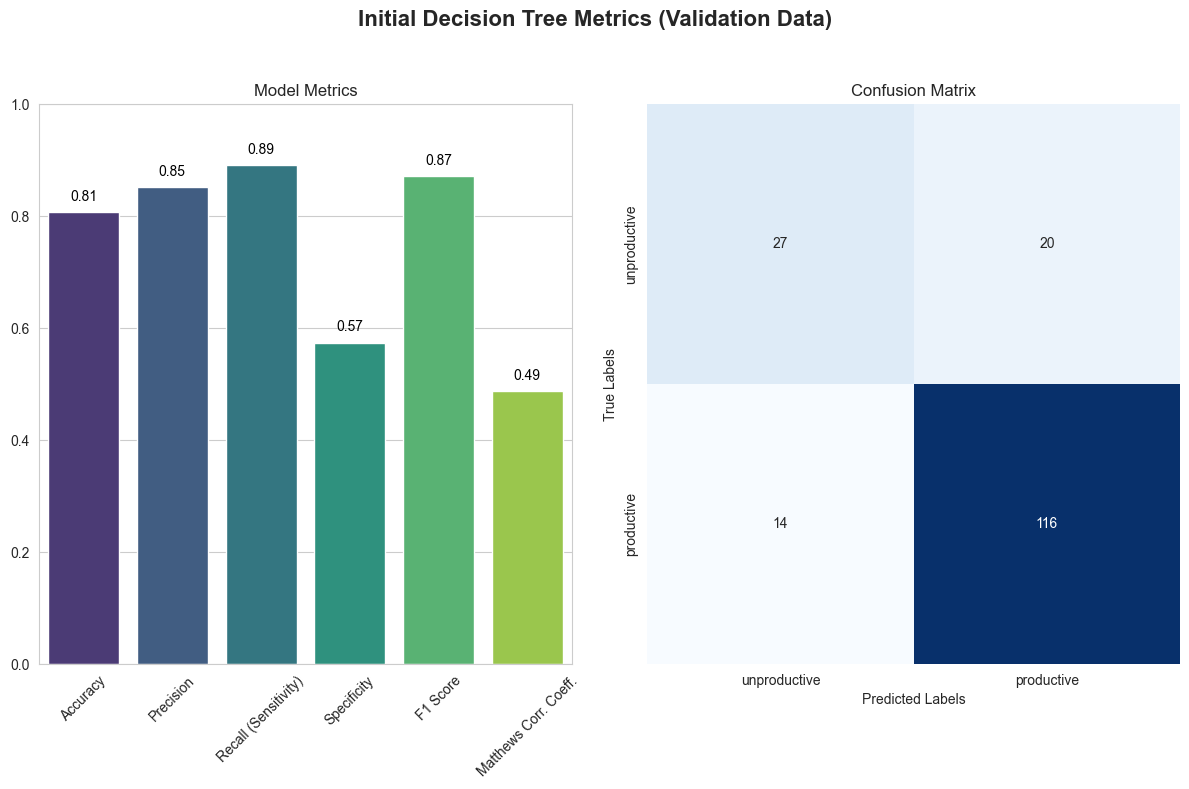

In [32]:
# Example usage:
display_model_stats(tree_pipeline, X_val, Y_val, title="Initial Decision Tree Metrics (Validation Data)")

## Model Evaluation <a id="model_evaluation"></a>

### Initial classifier results
The classifier is very good at determining productive shifts (sensitivity), but misses about half of the unproductive
 (specificity). The tree performs worse on the validation data. We're getting some overfitting, since some of the scores
 decrease between training data and validation data. Now that we can visualise the accuracy of
 the model, let's look at the tree itself. We're likely going to have difficulty with training on specificity because
  the random split of the training vs validation vs test data set may have many different reasons for a shift being
  unproductive.

### Tree visualisation
Having decision trees with a high score does not mean much if we can't show them to stakeholders.

In [33]:
tree_pipeline.named_steps['tree_model'].classes_

array([0, 1])

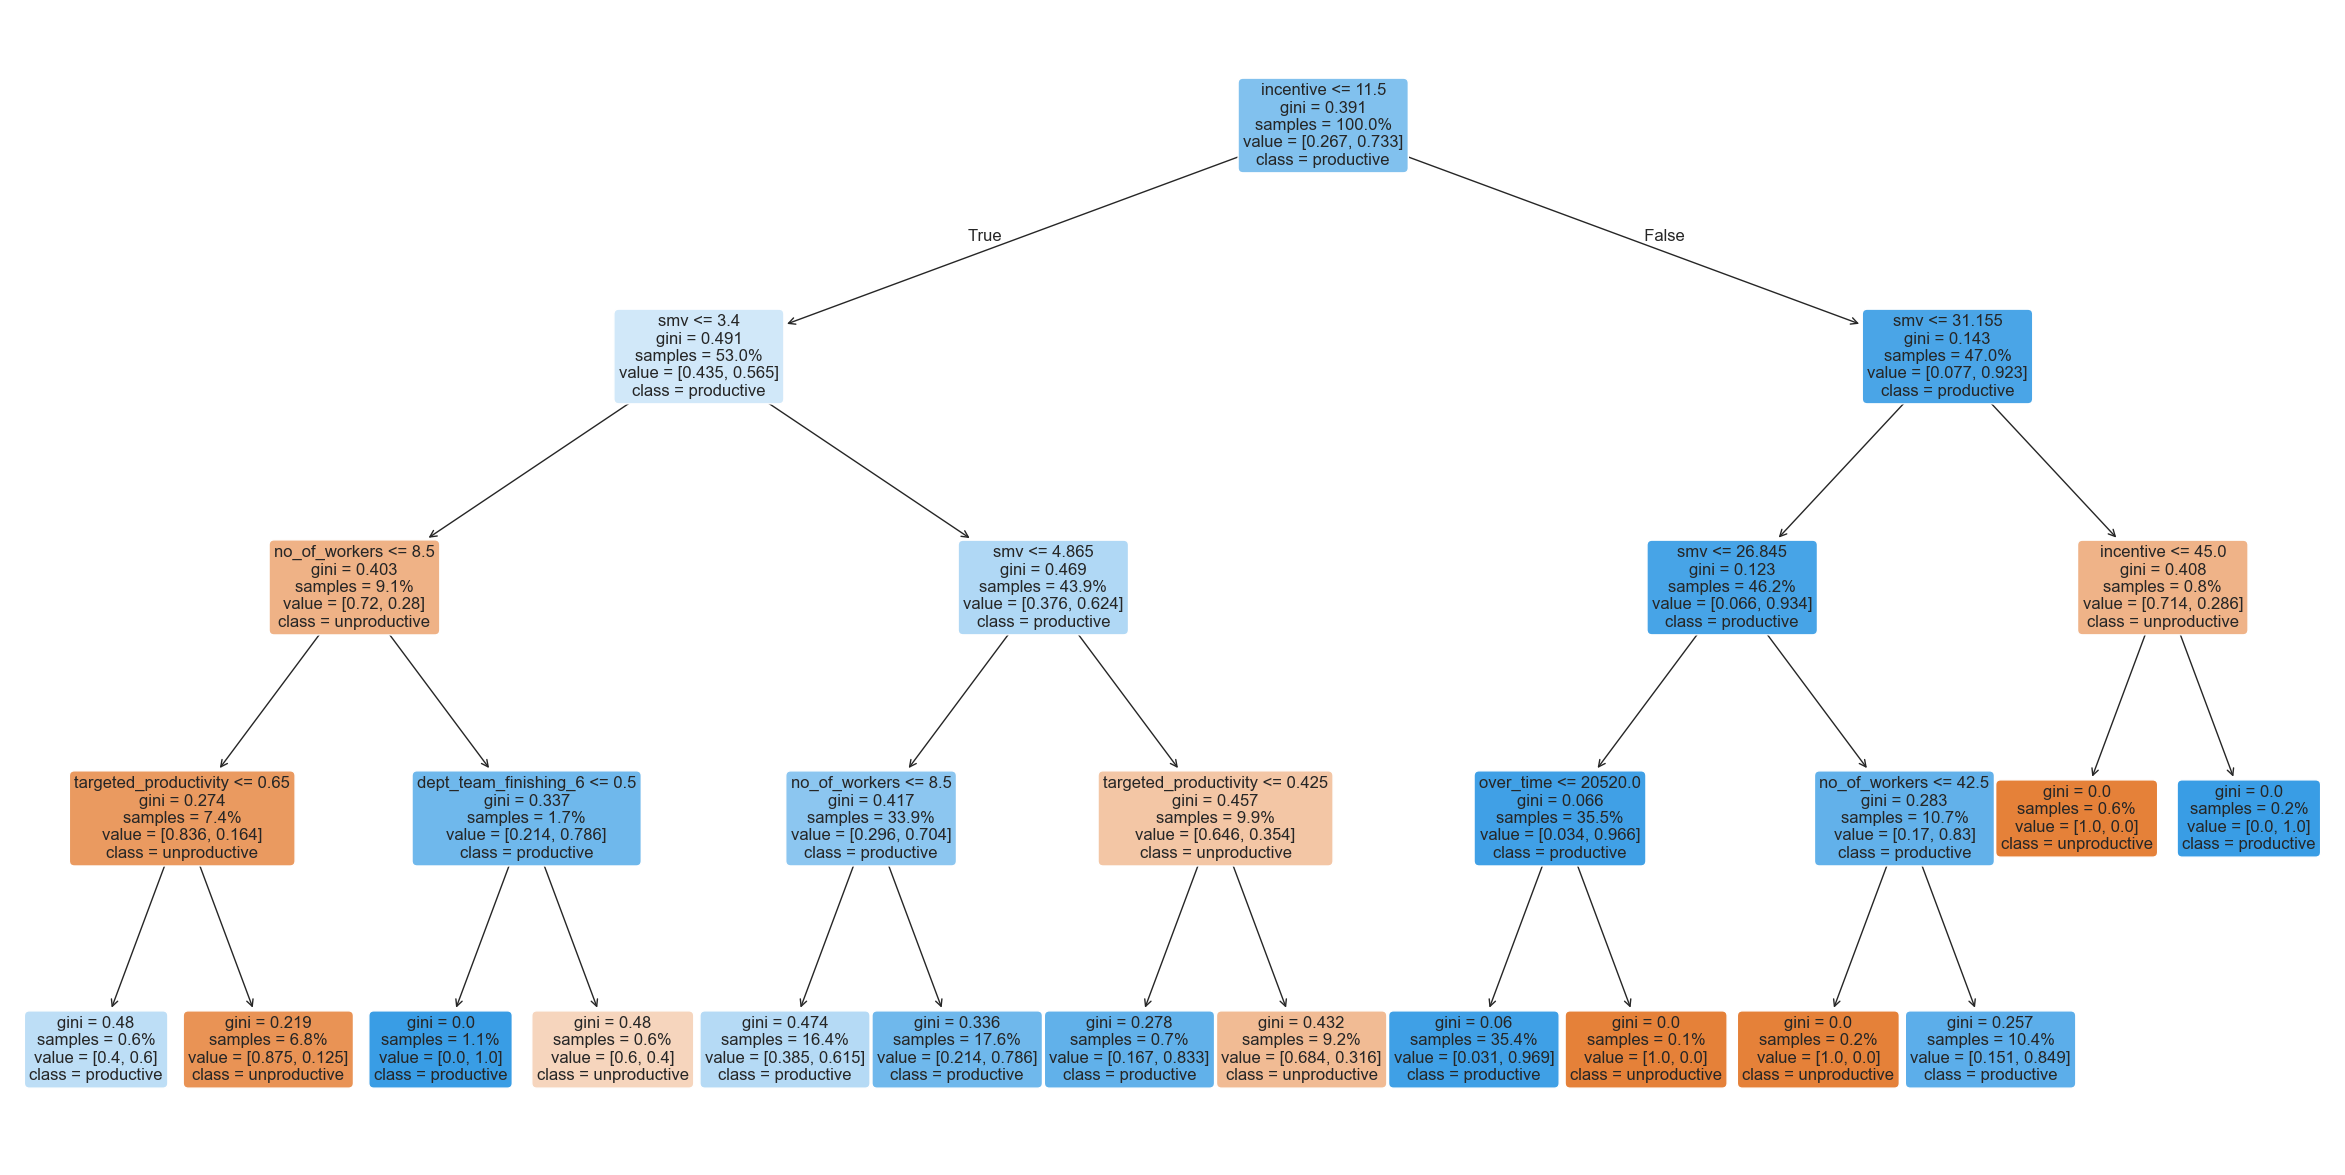

In [34]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Modify the feature names to remove pipeline prefixes or shorten them
clean_feature_names = [name.split('__')[-1] for name in data_cleaning_transformer.get_feature_names_out()]

plt.figure(figsize=(30, 15))
plot_tree(
    tree_pipeline.named_steps['tree_model'],
    feature_names=clean_feature_names,
    class_names=['unproductive', 'productive'],
    filled=True,
    rounded=True,
    proportion=True,
    fontsize=12
)
plt.show()

### Initial tree results
The decision tree indicates that `incentive` and `smv` are the two strongest predictors for whether the workers will
be productive. The works in progress cut off is interesting. There's also some interesting team based selection at
the 3rd layer. Still, we don't need to go into much detail for this tree, it's not the best tree, just an example of
how they can be visualised


### Improving tree visualisation
Let's see if we can get some different views of further down the tree when the depth is higher. The default view of
decision trees is fine for the data scientists, but for key stakeholders it would appear as incomprehensible without
extensive explanation. Let's use a module, called `dtreeviz` to visualise the trees instead.

In [35]:
import dtreeviz
from dtreeviz.utils import extract_params_from_pipeline
from sklearn.ensemble import BaseEnsemble


def visualise_tree_from_pipeline(input_pipeline, x_train, y_train, tree_index=0):
    # Extract model and transformed data from pipeline (without step_name parameter)
    try:
        tree_classifier, x1_train, features_model = extract_params_from_pipeline(
            input_pipeline,
            x_train,
            feature_names=input_pipeline.feature_names_in_.tolist()
        )
    except Exception as e:
        print(f"Error extracting parameters: {e}")
        return None, None

    # Handle ensemble models
    if isinstance(tree_classifier, BaseEnsemble):
        # Get list of individual estimators
        if hasattr(tree_classifier, 'estimators_'):
            try:
                tree_classifier = tree_classifier.estimators_[tree_index]
                print(f'Access Tree from Ensemble at index {tree_index}')
            except IndexError:
                raise ValueError(
                    f"Ensemble only has {len(tree_classifier.estimators_)} trees. Can't access index {tree_index}"
                )
        else:
            raise ValueError("This ensemble type doesn't contain individual tree estimators")

    # Clean feature names (handle sklearn's ColumnTransformer naming)
    features_model = [name.split('__')[-1] for name in features_model]

    # Ensure consistent feature names
    try:
        if isinstance(input_pipeline, ColumnTransformer):
            transformer_feature_names = input_pipeline.get_feature_names_out()
            features_model = list(transformer_feature_names)
        else:
            features_model = list(features_model)
    except Exception as e:
        print(f"Error cleaning features: {e}")
        return None, None

    # Create visualization model
    try:
        data_point = input_pipeline[:-1].transform(x_train.iloc[[3]])  # Exclude classifier
    except (AttributeError, IndexError):
        # Fallback for simple pipelines
        data_point = x_train.iloc[3]

    # Use the 'data' parameter to automatically handle feature mapping
    viz_model = dtreeviz.model(
        tree_classifier,
        X_train=x1_train,
        y_train=y_train,
        feature_names=features_model,
        class_names=['unproductive', 'productive'],
    )

    return viz_model, viz_model.view(x=data_point.iloc[0], scale=1.5, fancy=False)


example_tree, example_plot = visualise_tree_from_pipeline(tree_pipeline, X_train, Y_train)
example_plot.save('./example_tree.svg')

C:\Users\User\Dataquest.IO\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


<img src="./example_tree.svg" alt="Example Tree" />

### Improved tree visualisation
Dtreeviz gives us the ability to make the tree more readable to a general audience, as well as the ability to more
easily focus on different layers, or extract key insights. This will be important later when evaluating the
performance of a tree


### Explaining Decision Trees

A decision tree is a tool used to explain a predictive model. In this case, it helps us examine different factors that can be controlled and measured to predict an outcome. The outcome we care about is whether a team will meet or exceed their productivity target. We've classified these outcomes as either **productive** or **unproductive**.

At its core, a decision tree works like a flowchart. Each split in the tree asks a yes-or-no question based on one of the factors, such as: *Is the incentive greater than 11.50?* The answer determines which branch the data follows. This process continues until the data reaches an **endpoint**, called a **leaf node**, which represents the final prediction.

A perfect model, where all the right factors are measured and accounted for, would have leaf nodes that are completely uniform—every node would contain only productive or only unproductive outcomes. However, no model is perfect, so the leaf nodes usually have a mix of outcomes. The decision tree works to make these nodes as uniform as possible by splitting the data into meaningful groups.

The percentages in the leaf nodes represent the proportion of data points that belong to the predicted outcome. For example, if 80% of shifts in a node are productive, the tree predicts "productive" for inputs that reach this node. Higher percentages indicate greater confidence in the prediction, while lower percentages show more uncertainty.

The depth of the tree—how many layers of decisions there are before reaching the bottom—affects the balance between specificity and reliability. A deeper tree makes more specific predictions by accounting for smaller details in the data, but it can also risk **overfitting**, where the model focuses too much on the current data and fails to generalize well to new situations. For example, a deep tree might learn patterns unique to the dataset but irrelevant for future data. In this case, the tree has a depth of 4, meaning there are 4 layers of decisions before reaching the leaf nodes.

The highlighted path in orange shows how a single input flows through the tree. Here, the **incentive** is 30, the
**smv** (standard minute value) is 30.10. Based on these inputs, the tree
predicts a **productive** shift. If the **smv**  were less than 26.85, the tree would still predict a productive shift,
but with
 more confidence.

While decision trees are intuitive and easy to interpret, they have some limitations. For instance, they can struggle with noisy data or overly complex patterns, which can result in overfitting. Techniques like pruning (reducing the tree’s depth) or combining multiple trees in ensemble methods (e.g., random forests) can help address these challenges and improve accuracy.

By analyzing this decision tree, we can see how factors like team size, incentives, works in progress or standard
minute values influence productivity. This understanding can guide decisions to optimize team performance while keeping in mind the strengths and limitations of the model.



## Model Improvement <a id="model_improvement"></a>
Our first pass at the decision tree wasn't bad, but with an MCC score of 0.49, we can do better. Let's try a simple
random forest to start with.

### Random Forest
If we use a random forest method and have it optimise for the MCC score we'll get a better
model. The random forest works by creating many different decision trees based on subsamples of the training data and
scoring them.

In [36]:
from sklearn.ensemble import RandomForestClassifier

random_forest_pipeline = Pipeline(
    steps=[
            ('data_cleaning', data_cleaning_transformer),
            ('random_forest',
             RandomForestClassifier(random_state=42, n_estimators=100, max_depth=4,
                                    oob_score=matthews_corrcoef
                                    ))],
)


In [37]:
random_forest_pipeline.fit(X_train, Y_train)

Pipeline(steps=[('data_cleaning',
                 ColumnTransformer(transformers=[('dept_team',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['dept_team']),
                                                 ('style_change',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['no_of_style_change']),
                                                 ('scale_normalize',
                                                  Pipeline(steps=[('impute_zeros',
                                                                   CustomFunctionTransformer(feature_names_func=<function <lambda> at 0x000001AFB1EDCCC0>,
                                                                                             func=<functi...
                                                                   CustomFunctionTransformer(feature_names_func=<function <lambda> at 0x000001AFB1EDDF80>,
                                                                                             func=<function <lambda> at 0x000001AFB1EDDB20>,
                                                                                             kw_args={}))]),
                                                  ['no_of_workers',
                                                   'targeted_productivity',
                                                   'smv', 'wip',
                                                   'avg_overtime_per_worker',
                                                   'over_time',
                                                   'incentive'])])),
                ('random_forest',
                 RandomForestClassifier(max_depth=4,
                                        oob_score=<function matthews_corrcoef at 0x000001AFAC7BE0C0>,
                                        random_state=42))])

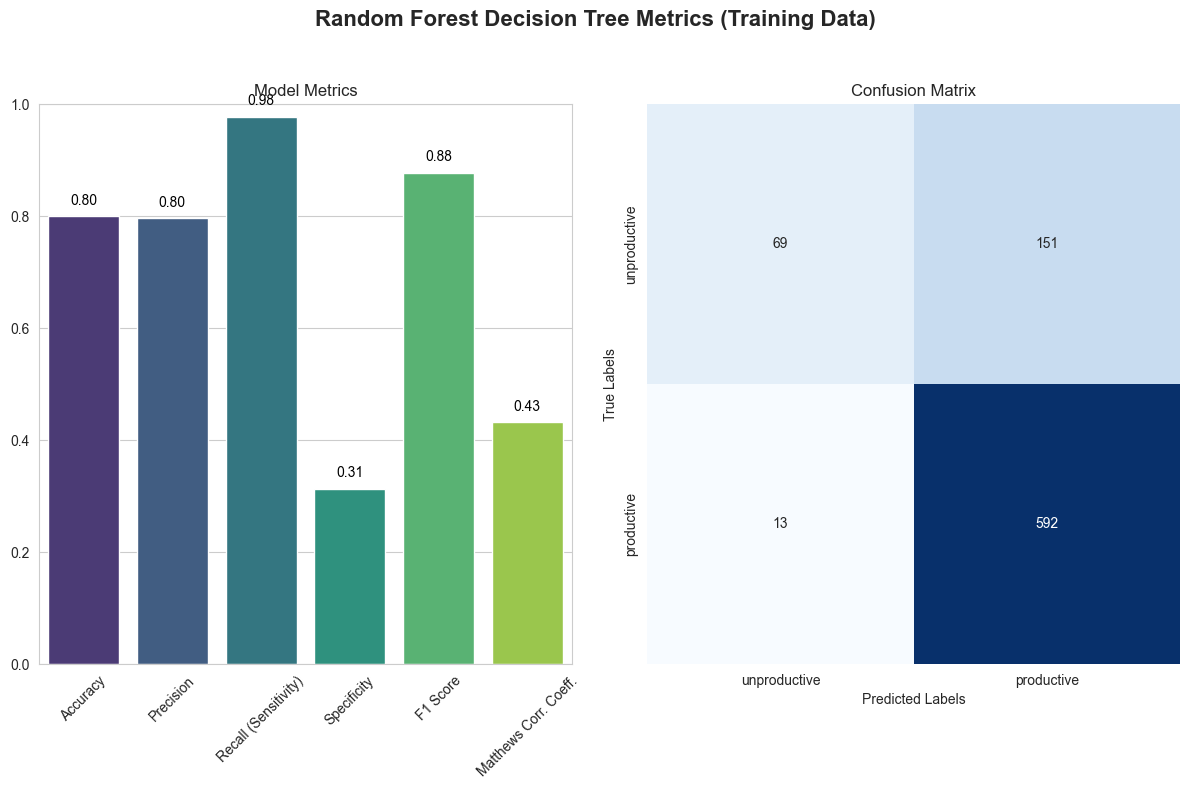

In [38]:
display_model_stats(random_forest_pipeline, X_train, Y_train,
                    title="Random Forest Decision Tree Metrics (Training Data)"
                    )

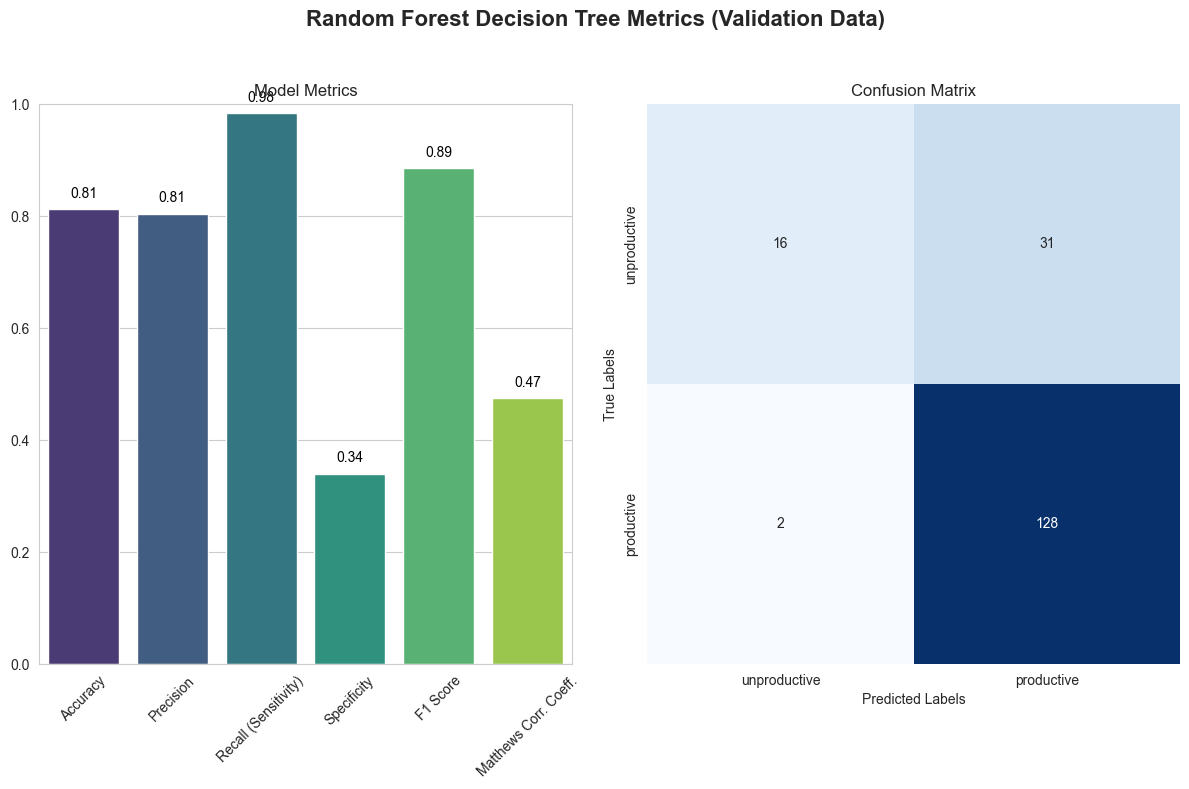

In [39]:
display_model_stats(
    random_forest_pipeline, X_val, Y_val, title='Random Forest Decision Tree '
                                                'Metrics (Validation Data)'
)

### Random Forest results
The difference between the random forest on the training data vs validation data suggests we're heavily overfitting
to the training set. The random forest has poor specificity, since it's predicting most shifts to be productive.

The random forest, when focused on F1 score has remained the same on the validation set with respect to the initial
decision tree. Accuracy, precision and specificity have all increased. The MCC has also improved from 0.43 to 0.47. In
 our random
forest classifier we specified a maximum depth of 4, which is probably too low for this data set.

### Hyperparameter search
We didn't build these pipelines for nothing. So let's do some hyperparameter searching. It'd be good to test if the
works in progress column and the assumption we're making about filling it with zeroes is better than dropping it. So
we can build that into our pipeline and test it.

In [40]:
# Define a clean transformer for 'wip' handling
def fill_or_drop_wip(x_data, action='fill'):
    """
    Handles the 'wip' column based on the action:
    - 'fill': Fill missing values with 0.
    - 'drop': Drop the column entirely.
    """
    if action == 'fill':
        x_data = x_data.copy()
        x_data['wip'] = x_data['wip'].fillna(0)
        return x_data
    elif action == 'drop':
        return x_data.drop(columns=['wip'], errors='ignore')
    return x_data


# Wrapping the fill/drop logic in CustomFunctionTransformer
fill_or_drop_transformer = CustomFunctionTransformer(
    func=lambda x_data, action='fill': fill_or_drop_wip(x_data, action=action),
    feature_names_func=lambda custom_transformer_feature_names: custom_transformer_feature_names,
    # No changes to feature names
    kw_args={'action': 'fill'}  # Default to 'fill'
)

# We'll basically make a copy of the data cleaning transformer pipeline, but we'll make it use the clean_wip
# transformer we've made

data_cleaning_transformer_1 = ColumnTransformer(
    transformers=[
            ('department', OneHotEncoder(sparse_output=False), ['department']),
            # ('style_change', OneHotEncoder(sparse_output=False), ['no_of_style_change']),
            # Clean or drop the WIP column
            ('clean_wip', fill_or_drop_transformer, ['wip']),
            # Scale/normalize numeric columns
            ('scale_normalize', Pipeline(
                steps=[
                        ('round_to_2_decimal', CustomFunctionTransformer(
                            func=lambda x: x.round(2),
                            feature_names_func=lambda x: x
                        ))
                ]
            ), ['targeted_productivity', 'smv', 'incentive', 'over_time', 'no_of_workers'])
    ],
    remainder='drop'
).set_output(transform="pandas")

# Define the pipeline
pipeline = Pipeline(
    steps=[
            ('data_cleaning', data_cleaning_transformer_1),
            ('random_forest', RandomForestClassifier(random_state=42, oob_score=matthews_corrcoef, bootstrap=True)),
    ]
)

# Define the parameter grid
param_grid = {
        # Use the action parameter to either fill or drop 'wip'
        'data_cleaning__clean_wip__kw_args': [{'action': 'fill'}, {'action': 'drop'}],
        # Random Forest hyperparameters
        'random_forest__n_estimators'      : [25, 50, 75],
        'random_forest__criterion'         : ['gini', 'entropy', 'log_loss'],
        'random_forest__max_depth'         : [5, 10, 15],
        'random_forest__min_samples_split' : [2, 3, 4, 5],
        'random_forest__min_samples_leaf'  : [1, 2, 3, 4, 5],
        'random_forest__max_features'      : ['sqrt', 'log2'],
        'random_forest__max_leaf_nodes'    : [50, 60, 65, 70, 75],
        'random_forest__bootstrap'         : [True],
        'random_forest__random_state'      : [42],
        'random_forest__warm_start'        : [True]

}

from sklearn.model_selection import RandomizedSearchCV


In [41]:

# Set up RandomizedSearchCV
random_grid_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_grid,
    n_iter=10000,  # Number of random samples to draw
    cv=5,
    scoring=mcc_scorer,  # Use MCC score as the evaluation metric
    random_state=42,
    n_jobs=-1  # Use all available cores
)

# Fit the grid search
random_grid_search.fit(X_train, Y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('data_cleaning',
                                              ColumnTransformer(transformers=[('department',
                                                                               OneHotEncoder(sparse_output=False),
                                                                               ['department']),
                                                                              ('clean_wip',
                                                                               CustomFunctionTransformer(feature_names_func=<function <lambda> at 0x000001AFB205DB20>,
                                                                                                         func=<function <lambda> at 0x000001AFB2096F20>,
                                                                                                         kw_args={'action': 'fill'}),
                                                                               ['wip']),
                                                                              ('scale_n...
                                        'random_forest__max_features': ['sqrt',
                                                                        'log2'],
                                        'random_forest__max_leaf_nodes': [50,
                                                                          60,
                                                                          65,
                                                                          70,
                                                                          75],
                                        'random_forest__min_samples_leaf': [1,
                                                                            2,
                                                                            3,
                                                                            4,
                                                                            5],
                                        'random_forest__min_samples_split': [2,
                                                                             3,
                                                                             4,
                                                                             5],
                                        'random_forest__n_estimators': [25, 50,
                                                                        75],
                                        'random_forest__random_state': [42],
                                        'random_forest__warm_start': [True]},
                   random_state=42,
                   scoring=make_scorer(matthews_corrcoef, response_method='predict'))

In [42]:

# Output the best parameters and score
print("Best random parameters:", random_grid_search.best_params_)
print("Best random MCC score:", random_grid_search.best_score_)


Best random parameters: {'random_forest__warm_start': True, 'random_forest__random_state': 42, 'random_forest__n_estimators': 50, 'random_forest__min_samples_split': 5, 'random_forest__min_samples_leaf': 3, 'random_forest__max_leaf_nodes': 60, 'random_forest__max_features': 'log2', 'random_forest__max_depth': 15, 'random_forest__criterion': 'gini', 'random_forest__bootstrap': True, 'data_cleaning__clean_wip__kw_args': {'action': 'fill'}}
Best random MCC score: 0.5587353307907114


In [43]:
# Display feature importances with transformed feature names
feature_importances = random_grid_search.best_estimator_.named_steps['random_forest'].feature_importances_

# Run the data_cleaning step to get the transformed data
transformed_data = random_grid_search.best_estimator_.named_steps['data_cleaning'].fit_transform(df)

# Extract feature names from the transformed data
feature_names = transformed_data.columns

# Combine feature names and their importance, then sort by importance
importances_df = pd.DataFrame({
        'Feature'   : feature_names,
        'Importance': feature_importances
}
).sort_values(by='Importance', ascending=False)

# Display the sorted feature importances
print(importances_df)

                                  Feature  Importance
4                    scale_normalize__smv    0.238300
5              scale_normalize__incentive    0.216572
7          scale_normalize__no_of_workers    0.203652
6              scale_normalize__over_time    0.134074
3  scale_normalize__targeted_productivity    0.100437
2                          clean_wip__wip    0.092937
0        department__department_finishing    0.009197
1           department__department_sewing    0.004831


### Hyperparameter search results
Most of the hyperparameters are not that exciting, but our search did yield that filling the WIP column with zeroes.
had a better result. As expected, the features that have the most impact are the `smv`, `incentive`, `over_time`,
`no_of_workers`. This fits with our mental model productivity is driven by those features.

## Model Results <a id="model_results"></a>

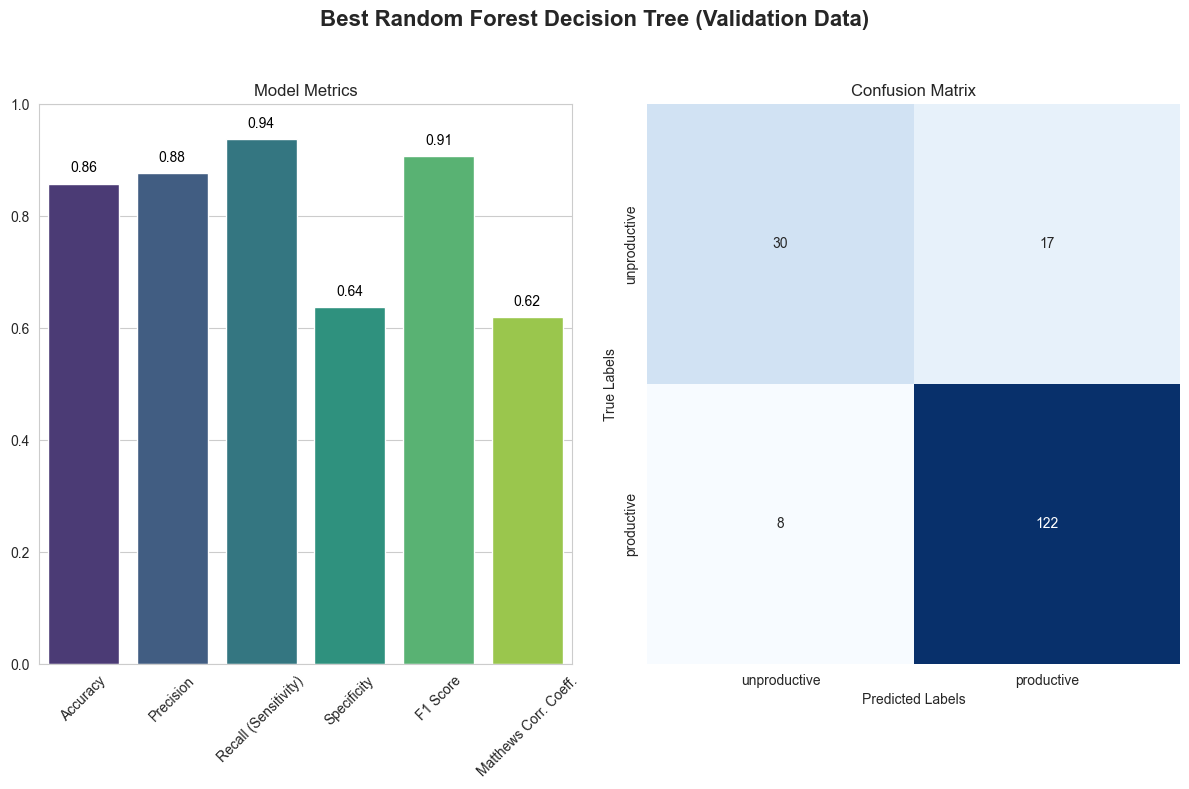

In [44]:
best_random_tree_model = random_grid_search.best_estimator_
display_model_stats(
    random_grid_search, X_val, Y_val, title='Best Random Forest Decision Tree '
                                            '(Validation Data)'
)


### Model results on validation data
In performing the randomized cross validation, we've found a slightly better model from the random forest optimisation,
moving from 0.53 to 0.56 for the
MCC on the validation data

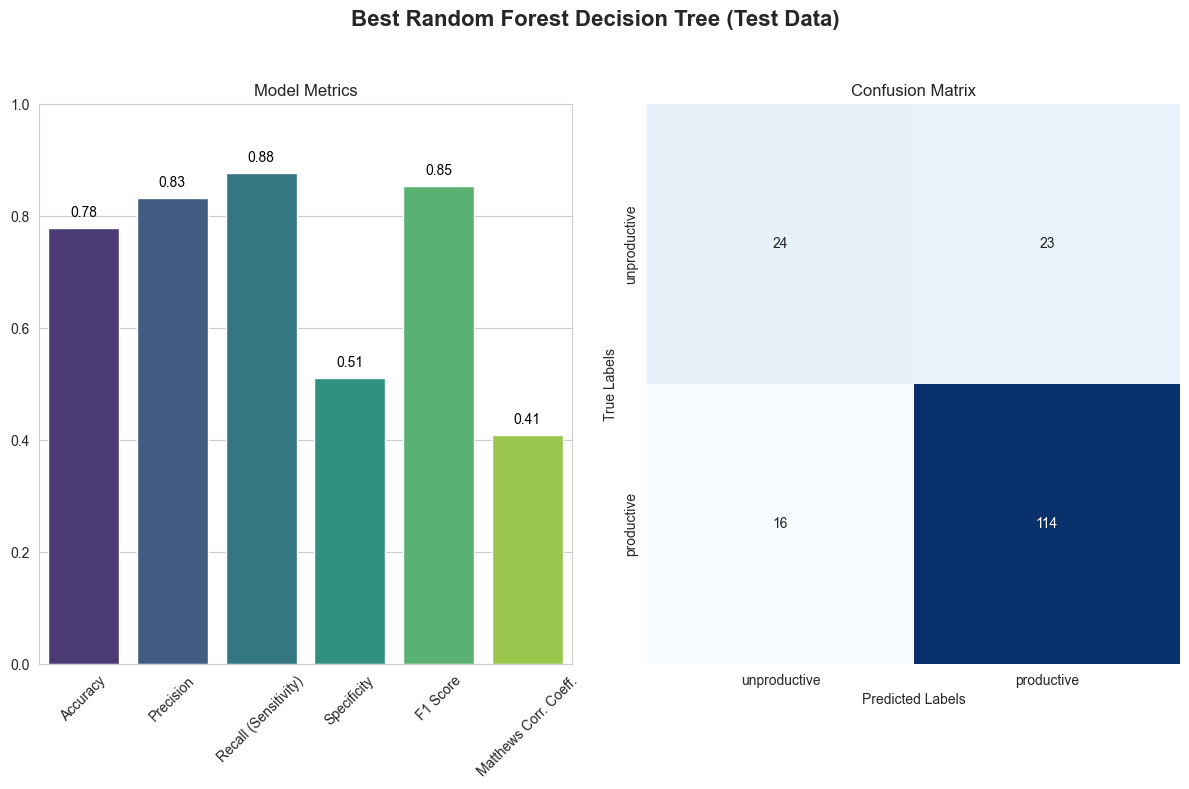

In [45]:
display_model_stats(
    best_random_tree_model, X_test, Y_test, title='Best Random Forest Decision Tree '
                                                  '(Test Data)'
)


### Model results on test data
On the test data, our search for a better decision tree through the random forest has revealed a flaw in the model, with
an MCC of 0.41 decreased from 0.62 on the validation set. The decision tree misclassified 14 extra measures in the
test set. Which represents about 10% of the size of the test set. It is probable that the random nature of the
training, validation and test data split has generated a test data set with imbalanced measures. The models have
significantly lower specificity compared to accuracy, precision and recall



### Visualising the decision tree
Lastly, lets look at the decision tree from that model and see what it looks like

In [46]:
final_vis = best_random_tree_model

In [47]:
final_tree, final_plot = visualise_tree_from_pipeline(final_vis, X_train, Y_train)

## These warnings can be ignored, pipelines don't return a value when they've been fitted

Access Tree from Ensemble at index 0


In [48]:
final_tree.view(fancy=False, scale=.4, title='Final Decision Tree (All layers)', title_fontsize=50,
                label_fontsize=50, orientation='TD', max_X_features_LR=5, max_X_features_TD=5,
                depth_range_to_display=(0, 15)
                )
final_plot.save('./final_tree_all_layers.svg')

<img src="./final_tree_all_layers.svg" alt="Final decision tree" />

The tree is huge, as expected. Since the optimum result had no maximum depth. The right side of the tree indicates
how the vast majority of productive shifts are reached in the training data.

In [49]:
final_tree.view(fancy=False, scale=1.5, title='Final Decision Tree (Layers 0 to 6)', title_fontsize=20,
                label_fontsize=50, orientation='TD', max_X_features_LR=5, max_X_features_TD=10,
                depth_range_to_display=(0, 6)
                ).save('./final_tree_layers_0_to_6.svg')

The final decision tree has many 15 layers, and 60 leaves, but many of those have only less than 5 samples, with a few
having over 20, let's take a look at the distribution of samples and classes within the leaves

When there is a sizeable incentive, shifts tend to be productive. The targeted productivity has an impact when it is
high, with many teams failing to meet productivity targets of 0.78 or higher

<img src="./final_tree_layers_0_to_6.svg" alt="Final Tree first 6 layers" />

## Conclusion <a id="conclusion"></a>
The owner of this garment factory has a challenge with meeting productivity targets. The two primary levers the owner
 can pull are the incentives offered, as well how many people are put on to work and the targeted productivity for a
 team. We have constructed a decision tree that is performant at predicting productive and unproductive shifts that
 generalises well to the type of data the owner is generating.

There are of course caveats. The decision tree generated has 60 leaf nodes. So it's comprehensibility beyond the
first six layers is limited.

The models performance is more than adequate, but will predict an unproductive shift incorrectly about half the time.

### Improving the model
The model can be improved by taking one of several avenues with the current data

1. Stratifying the data by date as well as productivity. We want to be able to take measurements from the past and
predict outcomes in the future. There may be some correlation between teams and departments on a single day that
impact productivity
2. Tweaking the hyperparameter search space and performing recursive feature selection. We want a model that
generalises well to unseen data and overfitting by considering too much data is problematic
3. Optimising for specificity, since owners care about productivity, and unproductive shifts are less prevalent,
optimising the model for them should improve performance.

### Questions for owners
In our generation of this decision tree, we had to make some assumptions about the data we've been given. Certain
questions being answered could drastically improve the model by improving our domain knowledge

1. Is the WIP (Works In Progress) for Finishing department really 0, or is there a systematic failure to enter the data?
2. Is there more data for a full year? There might be some temporal component to productivity related to seasons or
cultural events
3. How is the Standard Minute Value (SMV) determined for a garment?
4. How is the final figure of Actual Productivity calculated?

